In [1]:
%pip install datasets
%pip install accelerate -U
%pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none

In [30]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
import accelerate
import torch
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from google.colab import drive
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json

drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore", category=UserWarning)


Mounted at /content/drive


# ro-fb-offense

In [3]:
dataset = load_dataset("readerbench/ro-fb-offense")


Generating train split:   0%|          | 0/3564 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/891 [00:00<?, ? examples/s]

In [4]:
dataset


DatasetDict({
    train: Dataset({
        features: ['sender', 'no_reacts', 'text', 'label'],
        num_rows: 3564
    })
    test: Dataset({
        features: ['sender', 'no_reacts', 'text', 'label'],
        num_rows: 891
    })
})

In [5]:
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# Concatenate train and test data for a full overview (optional)
df_full = pd.concat([df_train, df_test])

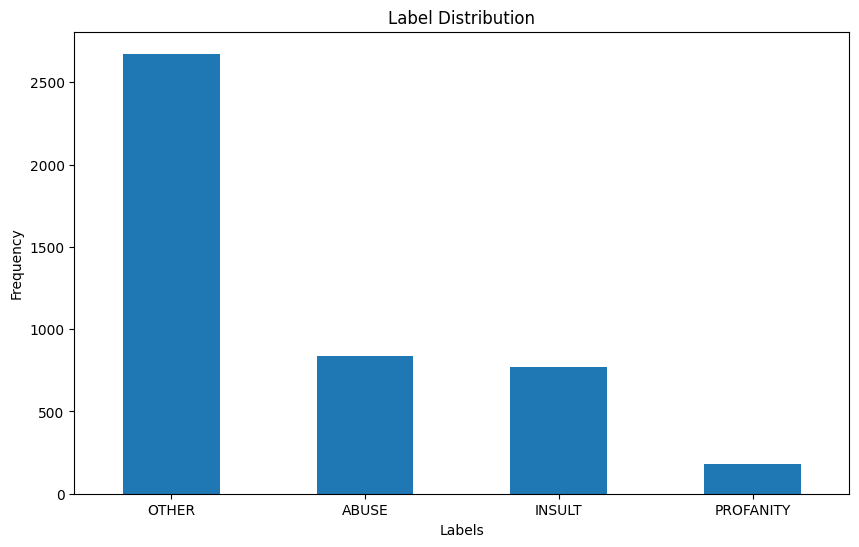

In [6]:
label_counts = df_full['label'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotates the labels on the x-axis so they are horizontal
plt.show()

In [7]:
label_dict = {'OTHER': 0, 'PROFANITY': 1, 'INSULT': 2, 'ABUSE': 3}
def label_map(example):
    example['label'] = label_dict[example['label']]
    return example

dataset = dataset.map(label_map)


Map:   0%|          | 0/3564 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

In [8]:
dataset['train'][0]

{'sender': '$USER0999',
 'no_reacts': 0,
 'text': 'Îl dăm pe iohanis Jos și arătat și pe tâlhari hoți și criminali de la putere????',
 'label': 0}

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("readerbench/RoBERT-base", num_labels=4)
tokenizer = AutoTokenizer.from_pretrained("readerbench/RoBERT-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/463M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/245k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3564 [00:00<?, ? examples/s]

Map:   0%|          | 0/891 [00:00<?, ? examples/s]

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # 'weighted' can be changed based on your label distribution
    return {'accuracy': acc, 'f1_score': f1}

In [12]:
output_path = r'/content/drive/My Drive/NLP/M3/results'
logging_path = r'/content/drive/My Drive/NLP/M3/logs'
training_args = TrainingArguments(
    output_dir=output_path,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir=logging_path,
    logging_steps=100,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,  # Add your compute_metrics function here
    tokenizer=tokenizer
)

In [13]:
train_result = trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,0.847200,0.771126,0.728395,0.738366
200,0.601300,0.452377,0.850730,0.842955
300,0.530700,0.414916,0.866442,0.862567
400,0.440900,0.435160,0.895623,0.891793
500,0.406800,0.508687,0.882155,0.878990
600,0.277200,0.531920,0.868687,0.871984
700,0.339100,0.467314,0.892256,0.892064
800,0.266300,0.491953,0.875421,0.877050
900,0.259500,0.543555,0.878788,0.878770
1000,0.131700,0.581955,0.896745,0.896230


In [14]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        5.0
  total_flos               =  1091678GF
  train_loss               =     0.2172
  train_runtime            = 0:04:29.16
  train_samples_per_second =     66.204
  train_steps_per_second   =      8.285


In [ ]:
# Load the data
file_path = '/content/drive/My Drive/NLP/M3/results/trainer_state.json'

with open(file_path, 'r') as file:
    trainer_state = json.load(file)

print(json.dumps(trainer_state, indent=4))


In [21]:
steps, train_loss, eval_loss, eval_accuracy, eval_f1_score = [], [], [], [], []

# Loop through each entry in the log history
for entry in trainer_state['log_history']:
    if 'loss' in entry and 'step' in entry:  # This indicates a training log
        steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry and 'step' in entry:  # This indicates an evaluation log
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1_score.append(entry['eval_f1_score'])

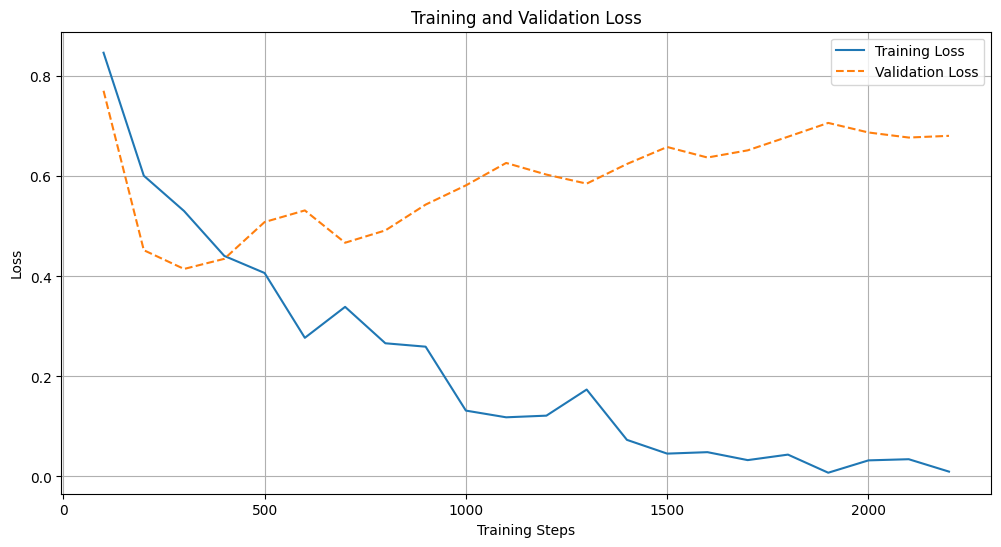

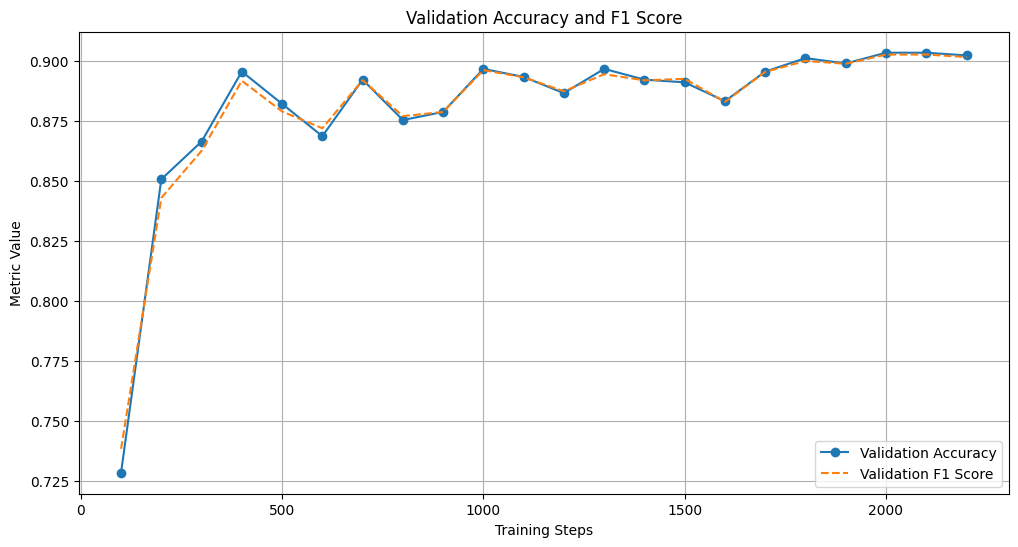

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy and F1 Score
plt.figure(figsize=(12, 6))
plt.plot(steps, eval_accuracy, label='Validation Accuracy', marker='o')
plt.plot(steps, eval_f1_score, label='Validation F1 Score', linestyle='--')
plt.title('Validation Accuracy and F1 Score')
plt.xlabel('Training Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
test_results = trainer.evaluate(dataset["test"])

# Print the results
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.6815454959869385, 'eval_accuracy': 0.9023569023569024, 'eval_f1_score': 0.9016605832399919, 'eval_runtime': 3.0653, 'eval_samples_per_second': 290.67, 'eval_steps_per_second': 18.269, 'epoch': 5.0}


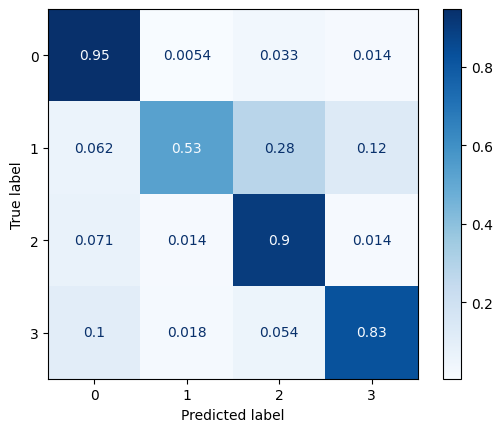

In [31]:
predictions = trainer.predict(dataset["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# ro-offense

In [69]:
dataset = load_dataset("readerbench/ro-offense")


In [70]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 9953
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 2492
    })
})

In [71]:
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# Concatenate train and test data for a full overview (optional)
df_full = pd.concat([df_train, df_test])

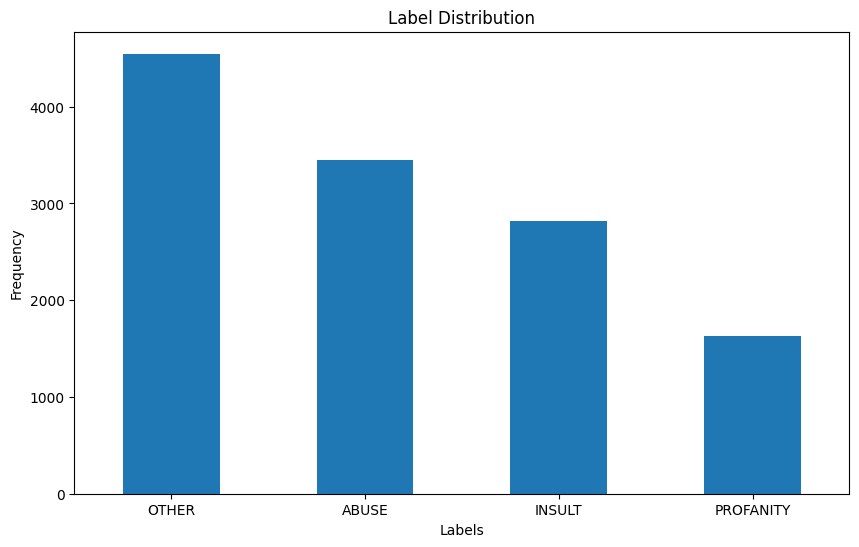

In [72]:
label_counts = df_full['label'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotates the labels on the x-axis so they are horizontal
plt.show()

In [73]:
model_ro = AutoModelForSequenceClassification.from_pretrained("readerbench/RoBERT-base", num_labels=4)
tokenizer_ro = AutoTokenizer.from_pretrained("readerbench/RoBERT-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
label_dict = {'OTHER': 0, 'PROFANITY': 1, 'INSULT': 2, 'ABUSE': 3}
def label_map(example):
    example['label'] = label_dict[example['label']]
    return example

dataset = dataset.map(label_map)

In [75]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)

In [76]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # 'weighted' can be changed based on your label distribution
    return {'accuracy': acc, 'f1_score': f1}

In [77]:
output_path = r'/content/drive/My Drive/NLP/M3/ro-offense/results'
logging_path = r'/content/drive/My Drive/NLP/M3/ro-offense/logs'
training_args = TrainingArguments(
    output_dir=output_path,
    evaluation_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir=logging_path,
    logging_steps=500,
    save_strategy="epoch"
)

trainer = Trainer(
    model=model_ro,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,  # Add your compute_metrics function here
    tokenizer=tokenizer_ro
)

In [78]:
train_result = trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.977400,0.669954,0.714687,0.677601
1000,0.643100,0.578029,0.782905,0.786522
1500,0.514800,0.549150,0.813002,0.817105
2000,0.441700,0.552532,0.827849,0.827098
2500,0.444600,0.515829,0.827448,0.826778
3000,0.321500,0.608906,0.830257,0.832058
3500,0.307800,0.635062,0.822231,0.822638
4000,0.273100,0.705812,0.820225,0.820156
4500,0.206000,0.796597,0.822632,0.824380
5000,0.226800,0.828336,0.821429,0.824073


In [79]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =        5.0
  total_flos               =  3048674GF
  train_loss               =      0.381
  train_runtime            = 0:10:10.62
  train_samples_per_second =     81.498
  train_steps_per_second   =     10.194


In [80]:
# Load the data
file_path = '/content/drive/My Drive/NLP/M3/ro-offense/results/trainer_state.json'

with open(file_path, 'r') as file:
    trainer_state = json.load(file)

print(json.dumps(trainer_state, indent=4))

{
    "best_metric": null,
    "best_model_checkpoint": null,
    "epoch": 5.0,
    "eval_steps": 500,
    "global_step": 6225,
    "is_hyper_param_search": false,
    "is_local_process_zero": true,
    "is_world_process_zero": true,
    "log_history": [
        {
            "epoch": 0.40160642570281124,
            "grad_norm": 21.38939666748047,
            "learning_rate": 9.196787148594378e-06,
            "loss": 0.9774,
            "step": 500
        },
        {
            "epoch": 0.40160642570281124,
            "eval_accuracy": 0.7146869983948636,
            "eval_f1_score": 0.6776008215121342,
            "eval_loss": 0.6699544191360474,
            "eval_runtime": 6.2423,
            "eval_samples_per_second": 399.21,
            "eval_steps_per_second": 24.991,
            "step": 500
        },
        {
            "epoch": 0.8032128514056225,
            "grad_norm": 21.060821533203125,
            "learning_rate": 8.393574297188756e-06,
            "loss": 0.6431,


In [81]:
steps, train_loss, eval_loss, eval_accuracy, eval_f1_score = [], [], [], [], []

# Loop through each entry in the log history
for entry in trainer_state['log_history']:
    if 'loss' in entry and 'step' in entry:  # This indicates a training log
        steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry and 'step' in entry:  # This indicates an evaluation log
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1_score.append(entry['eval_f1_score'])

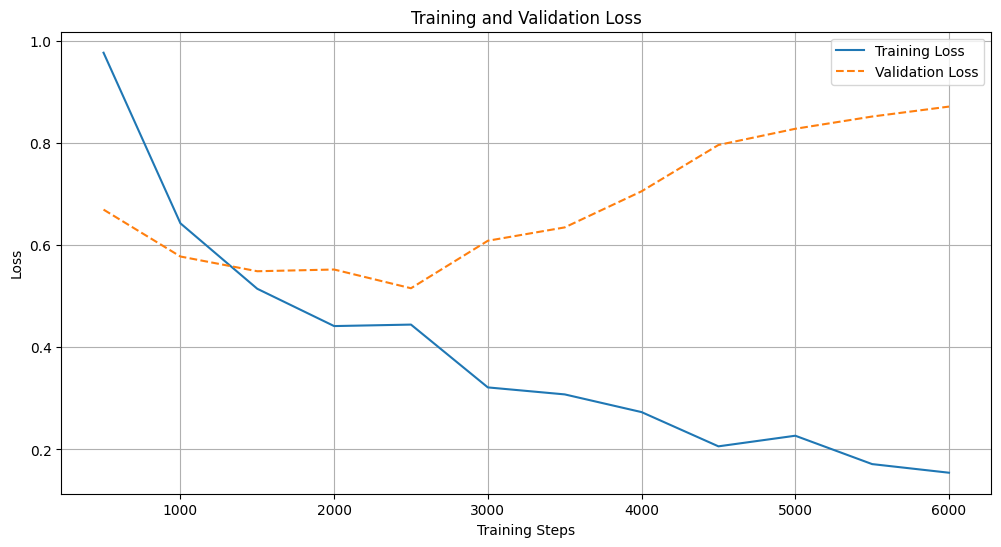

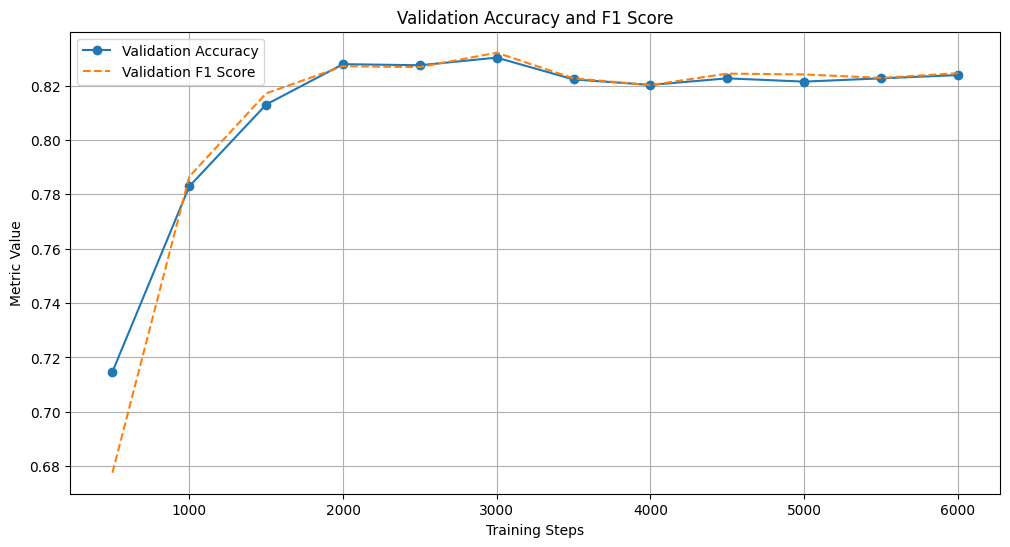

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy and F1 Score
plt.figure(figsize=(12, 6))
plt.plot(steps, eval_accuracy, label='Validation Accuracy', marker='o')
plt.plot(steps, eval_f1_score, label='Validation F1 Score', linestyle='--')
plt.title('Validation Accuracy and F1 Score')
plt.xlabel('Training Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
test_results = trainer.evaluate(dataset["test"])

# Print the results
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.8747888803482056, 'eval_accuracy': 0.8214285714285714, 'eval_f1_score': 0.822538042910367, 'eval_runtime': 9.3744, 'eval_samples_per_second': 265.83, 'eval_steps_per_second': 16.641, 'epoch': 5.0}


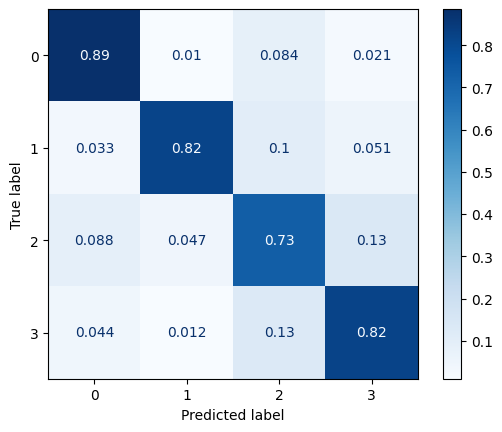

In [84]:
predictions = trainer.predict(dataset["test"])

# Get the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()